In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import optuna
import warnings
warnings.filterwarnings('ignore')
from read_data import DataLoader
# === Configuration ===
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 7)
sns.set_palette("viridis")
np.random.seed(42)

In [3]:
loader= DataLoader()
df= loader.load_data()

In [4]:
"""file_id = "1c222AbSUMn9vKcepLZDnyCKUN2B8BQtP"
url = f"https://drive.google.com/uc?export=download&id={file_id}"
df= pd.read_csv(url)"""
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,temp,humidity,conditions
datetime,,,,,,,,,,
2006-12-17,1.044,0.152,242.73,4.4,0.0,2.0,0.0,3.94,91.1,"Rain, Partially cloudy"
2006-12-18,0.278,0.126,246.17,1.2,0.0,2.0,0.0,4.39,87.5,"Rain, Partially cloudy"
2006-12-19,0.414,0.242,241.19,2.0,0.0,1.0,0.0,2.44,78.8,Partially cloudy
2006-12-20,0.824,0.058,245.57,3.4,0.0,0.0,0.0,2.72,72.3,Partially cloudy
2006-12-21,1.814,0.148,243.51,7.6,0.0,0.0,18.0,4.83,76.3,Partially cloudy


In [5]:
# One hot encoding for categorical variables
df = pd.get_dummies(df, columns=['conditions'], drop_first=True)
# standardize the data
scaler = MinMaxScaler()
scale_df= scaler.fit_transform(df)
scale_df = pd.DataFrame(scale_df, columns=df.columns, index=df.index)

In [6]:
# Create time series dataset for Sarimax model
ts_data = scale_df[['Global_active_power']].copy()

# Split data (last 9 months for test)
split_date = '2010-03-01'
train = ts_data[ts_data.index < split_date]
test = ts_data[ts_data.index >= split_date]

print(f"Train size: {train.shape[0]} days ({train.index.min().date()} to {train.index.max().date()})")
print(f"Test size: {test.shape[0]} days ({test.index.min().date()} to {test.index.max().date()})")

Train size: 1170 days (2006-12-17 to 2010-02-28)
Test size: 271 days (2010-03-01 to 2010-11-26)


In [7]:


# === SARIMAX Hyperparameter Tuning with Optuna ===
def sarimax_objective(trial):
    p = trial.suggest_int('p', 0, 5)
    d = trial.suggest_int('d', 0, 1)
    q = trial.suggest_int('q', 0, 5)
    P = trial.suggest_int('P', 0, 2)
    D = trial.suggest_int('D', 0, 1)
    Q = trial.suggest_int('Q', 0, 2)
    s = trial.suggest_categorical('s', [7, 14, 30])
    
    try:
        model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
        model_fit = model.fit(disp=False)
        aic = model_fit.aic
        return aic
    except:
        return float('inf')

# Optimize SARIMAX parameters
sarimax_study = optuna.create_study(direction='minimize')
sarimax_study.optimize(sarimax_objective, n_trials=50)

# Get best parameters
best_sarimax_params = sarimax_study.best_params
print(f"Best SARIMAX parameters: {best_sarimax_params}")

# Train and evaluate SARIMAX
sarimax_model = SARIMAX(train, order=(
    best_sarimax_params['p'], 
    best_sarimax_params['d'], 
    best_sarimax_params['q']
), seasonal_order=(
    best_sarimax_params['P'], 
    best_sarimax_params['D'], 
    best_sarimax_params['Q'], 
    best_sarimax_params['s']
)
)
sarimax_fit = sarimax_model.fit(disp=False)
sarimax_pred = sarimax_fit.get_forecast(steps=len(test)).predicted_mean

[I 2025-06-03 15:50:08,430] A new study created in memory with name: no-name-9d484bb2-75c5-4b93-9d34-05eaa6149b56
[I 2025-06-03 15:50:11,389] Trial 0 finished with value: -1275.879395928199 and parameters: {'p': 4, 'd': 0, 'q': 4, 'P': 1, 'D': 0, 'Q': 2, 's': 7}. Best is trial 0 with value: -1275.879395928199.
[I 2025-06-03 15:50:12,249] Trial 1 finished with value: -1225.1855579384865 and parameters: {'p': 2, 'd': 0, 'q': 5, 'P': 0, 'D': 0, 'Q': 0, 's': 7}. Best is trial 0 with value: -1275.879395928199.
[I 2025-06-03 15:50:18,057] Trial 2 finished with value: -867.7781341272587 and parameters: {'p': 0, 'd': 0, 'q': 2, 'P': 2, 'D': 1, 'Q': 0, 's': 30}. Best is trial 0 with value: -1275.879395928199.
[I 2025-06-03 15:51:22,303] Trial 3 finished with value: -1071.337217745366 and parameters: {'p': 4, 'd': 1, 'q': 1, 'P': 2, 'D': 1, 'Q': 1, 's': 30}. Best is trial 0 with value: -1275.879395928199.
[I 2025-06-03 15:51:23,990] Trial 4 finished with value: -570.359295890615 and parameters: 

Best SARIMAX parameters: {'p': 2, 'd': 0, 'q': 1, 'P': 0, 'D': 1, 'Q': 1, 's': 7}


SARIMAX Evaluation:
MAE: 0.4194, MSE: 0.3698, RMSE: 0.6081, R2: -0.0026


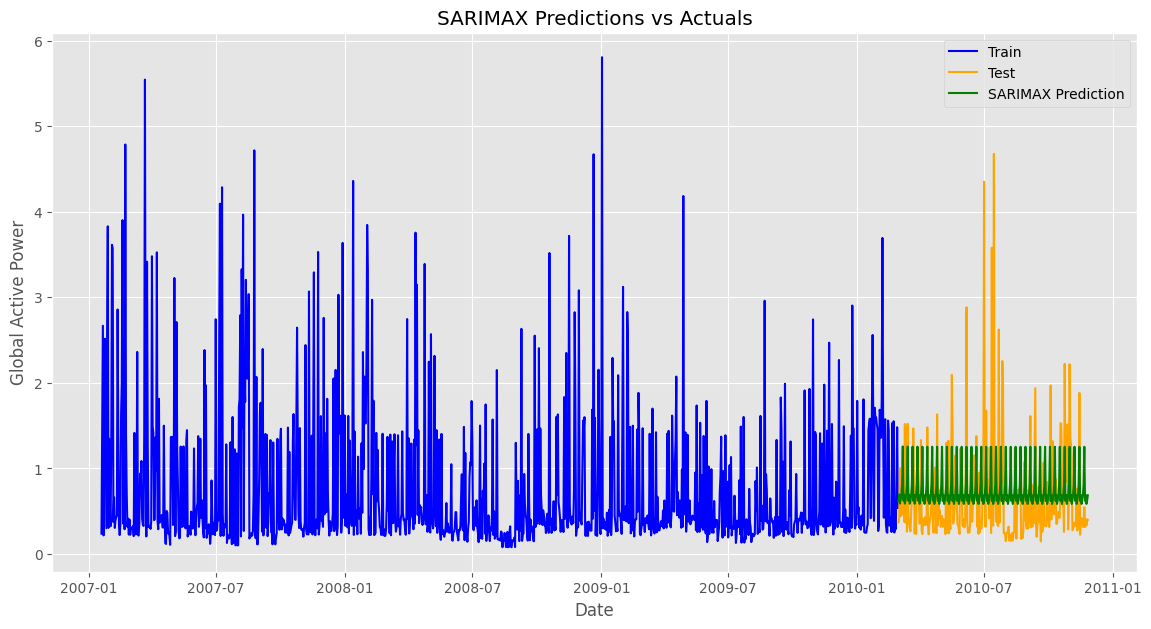

In [24]:
# Train SARIMAX with additional features
sarimax_model = SARIMAX(train['Global_active_power'], 
                        order=(best_sarimax_params['p'], 
                               best_sarimax_params['d'], 
                               best_sarimax_params['q']),
                        seasonal_order=(best_sarimax_params['P'], 
                                        best_sarimax_params['D'], 
                                        best_sarimax_params['Q'], 
                                        best_sarimax_params['s'])
                       )
sarimax_fit = sarimax_model.fit(disp=False)
sarimax_pred = sarimax_fit.get_forecast(steps=len(test)).predicted_mean
# Evaluate SARIMAX
mae = mean_absolute_error(test['Global_active_power'], sarimax_pred)
mse = mean_squared_error(test['Global_active_power'], sarimax_pred)
rmse = np.sqrt(mse)
r2 = r2_score(test['Global_active_power'], sarimax_pred)
print(f"SARIMAX Evaluation:\nMAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")
# Plot SARIMAX predictions
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Global_active_power'], label='Train', color='blue')
plt.plot(test.index, test['Global_active_power'], label='Test', color='orange')
plt.plot(test.index, sarimax_pred, label='SARIMAX Prediction', color='green')
plt.title('SARIMAX Predictions vs Actuals')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()

SARIMAX with Features Evaluation:
MAE: 0.3646, MSE: 0.3073, RMSE: 0.5544, R2: 0.1668


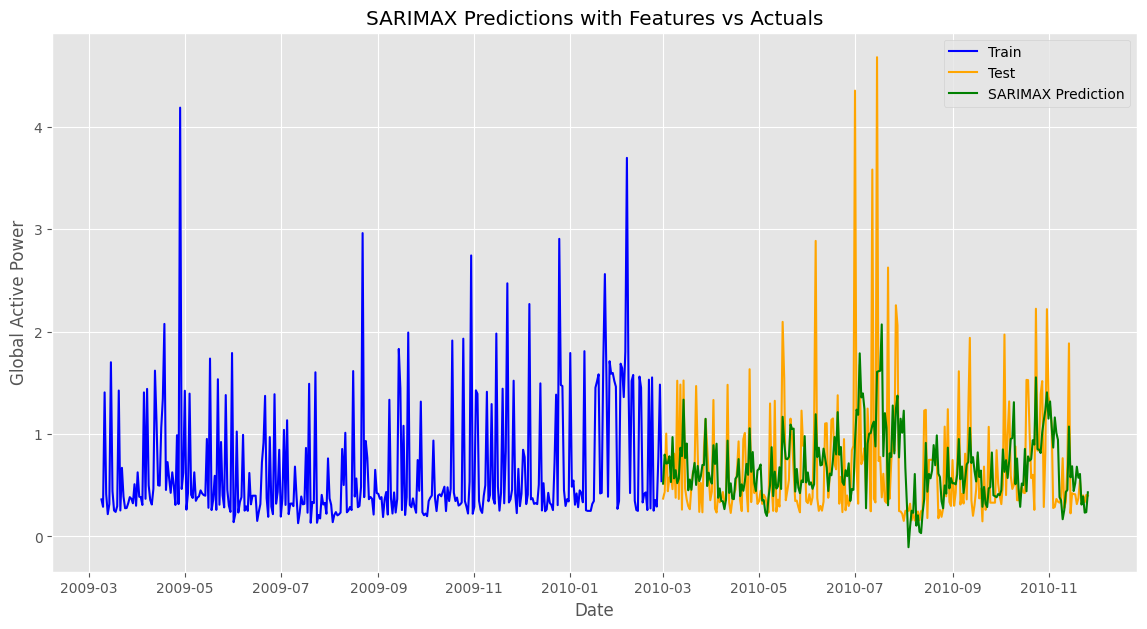

In [52]:
df['GAP_lag1'] = df['Global_active_power'].shift(1)
df['GAP_lag7'] = df['Global_active_power'].shift(7)
df['GAP_lag30'] = df['Global_active_power'].shift(30)
df['GAP_rolling_mean7'] = df['Global_active_power'].rolling(window=7).mean()
df['GAP_rolling_mean30'] = df['Global_active_power'].rolling(window=30).mean()
df['GAP_rolling_std7'] = df['Global_active_power'].rolling(window=7).std()
df['GAP_rolling_std30'] = df['Global_active_power'].rolling(window=30).std()
df['GAP_rolling_max7'] = df['Global_active_power'].rolling(window=7).max()
df['GAP_rolling_max30'] = df['Global_active_power'].rolling(window=30).max()
df['GAP_rolling_min7'] = df['Global_active_power'].rolling(window=7).min()
df['GAP_rolling_min30'] = df['Global_active_power'].rolling(window=30).min()
# Drop NaN values created by rolling operations
df.dropna(inplace=True)
# Split data again after feature engineering
train = df[df.index < split_date]
test = df[df.index >= split_date]
# Convert boolean columns to int for SARIMAX exogenous variables

train_exog = train[['GAP_lag7',
                    'GAP_rolling_mean7',
                    ]]
test_exog = test[['GAP_lag7',
                   'GAP_rolling_mean7',
                   ]]
for col in train_exog.select_dtypes(include='bool').columns:
    train_exog[col] = train_exog[col].astype(int)
    test_exog[col] = test_exog[col].astype(int)

# Train SARIMAX with additional features
sarimax_model = SARIMAX(
    train['Global_active_power'],
    exog=train_exog,
    order=(best_sarimax_params['p'],
           best_sarimax_params['d'],
           best_sarimax_params['q']),
    seasonal_order=(best_sarimax_params['P'],
                    best_sarimax_params['D'],
                    best_sarimax_params['Q'],
                    best_sarimax_params['s'])
)
sarimax_fit = sarimax_model.fit(disp=False)
sarimax_pred = sarimax_fit.get_forecast(steps=len(test), exog=test_exog).predicted_mean
# Evaluate SARIMAX with additional features
mae = mean_absolute_error(test['Global_active_power'], sarimax_pred)
mse = mean_squared_error(test['Global_active_power'], sarimax_pred)
rmse = np.sqrt(mse)
r2 = r2_score(test['Global_active_power'], sarimax_pred)
print(f"SARIMAX with Features Evaluation:\nMAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")
# Plot SARIMAX predictions with additional features
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Global_active_power'], label='Train', color='blue')
plt.plot(test.index, test['Global_active_power'], label='Test', color='orange')
plt.plot(test.index, sarimax_pred, label='SARIMAX Prediction', color='green')
plt.title('SARIMAX Predictions with Features vs Actuals')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()

SARIMAX with Weather Features Evaluation:
MAE: 0.3917, MSE: 0.3933, RMSE: 0.6272, R2: -0.0663


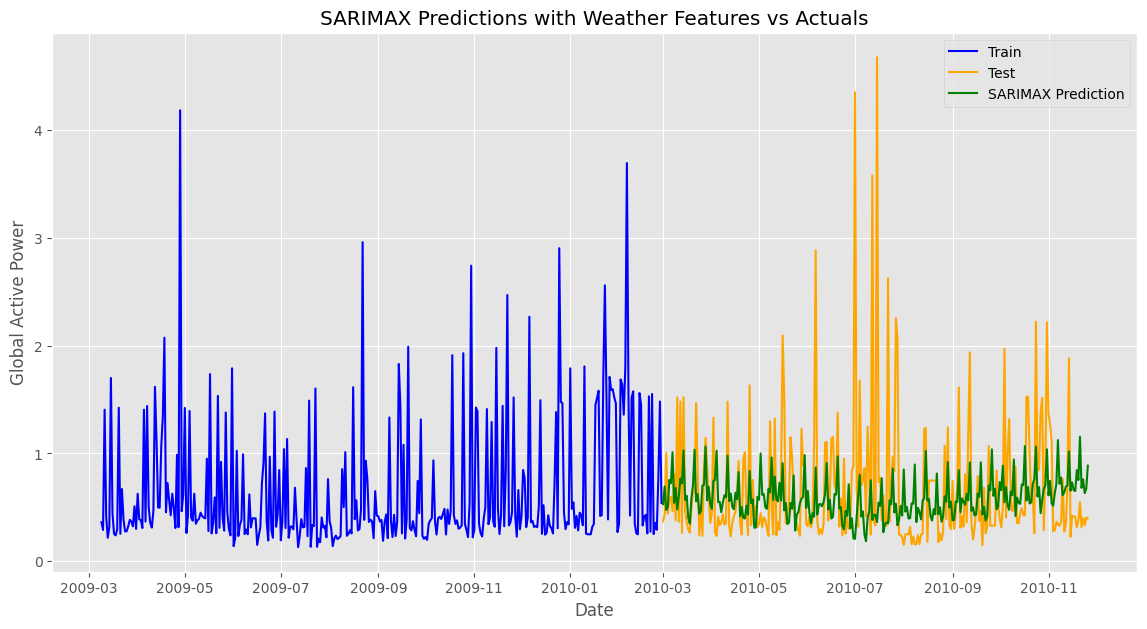

In [57]:
train_exog = train[['humidity','temp'
                   ]]
test_exog = test[['humidity', 'temp'
                  ]]
sarimax_model = SARIMAX(train['Global_active_power'],
                        exog=train_exog,
                        order=(best_sarimax_params['p'], 
                               best_sarimax_params['d'], 
                               best_sarimax_params['q']),
                        seasonal_order=(best_sarimax_params['P'], 
                                        best_sarimax_params['D'], 
                                        best_sarimax_params['Q'], 
                                        best_sarimax_params['s'])
                       )
sarimax_fit = sarimax_model.fit(disp=False)
sarimax_pred = sarimax_fit.get_forecast(steps=len(test), exog=test_exog).predicted_mean
# Evaluate SARIMAX with weather features
mae = mean_absolute_error(test['Global_active_power'], sarimax_pred)
mse = mean_squared_error(test['Global_active_power'], sarimax_pred)
rmse = np.sqrt(mse)
r2 = r2_score(test['Global_active_power'], sarimax_pred)
print(f"SARIMAX with Weather Features Evaluation:\nMAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")
# Plot SARIMAX predictions with weather features
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Global_active_power'], label='Train', color='blue')
plt.plot(test.index, test['Global_active_power'], label='Test', color='orange')
plt.plot(test.index, sarimax_pred, label='SARIMAX Prediction', color='green')
plt.title('SARIMAX Predictions with Weather Features vs Actuals')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()


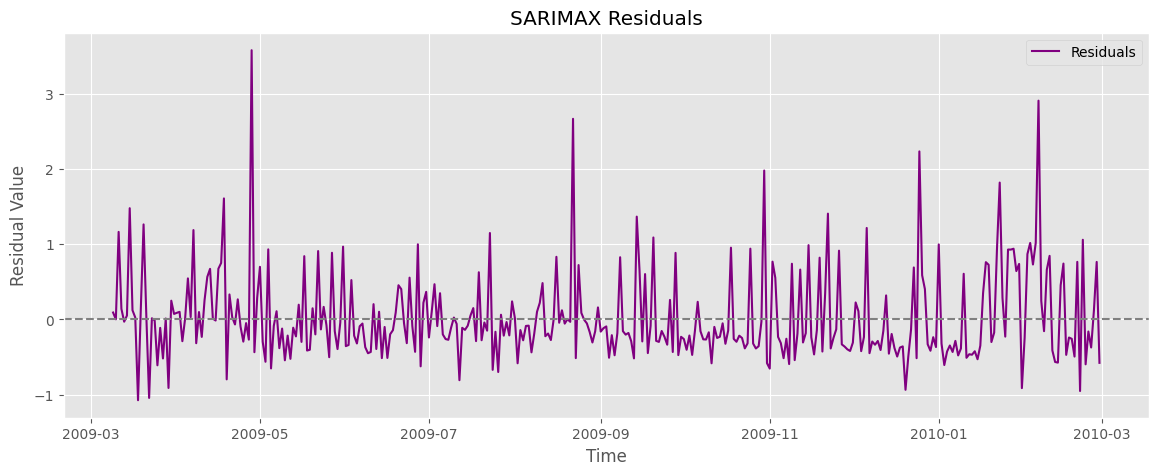

In [58]:
# Extract residuals from SARIMAX model
residuals = sarimax_fit.resid
# Plot residuals
plt.figure(figsize=(14, 5))
plt.plot(residuals, label="Residuals", color="purple")
plt.axhline(y=0, linestyle="--", color="gray")  # Reference line at zero
plt.title("SARIMAX Residuals")
plt.xlabel("Time")
plt.ylabel("Residual Value")
plt.legend()
plt.show()


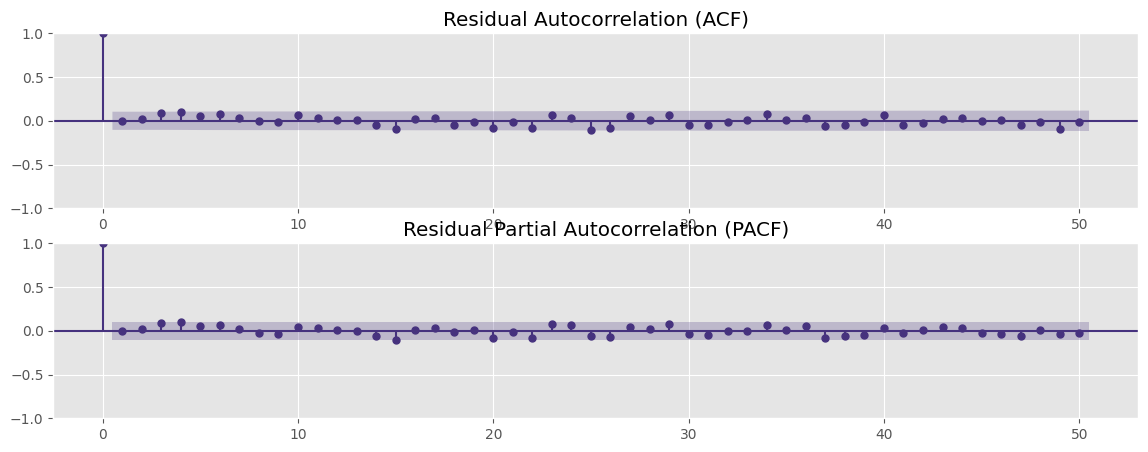

In [59]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2, figsize=(14, 5))
plot_acf(residuals, lags=50, ax=ax[0])
plot_pacf(residuals, lags=50, ax=ax[1])
ax[0].set_title("Residual Autocorrelation (ACF)")
ax[1].set_title("Residual Partial Autocorrelation (PACF)")
plt.show()


In [60]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(residuals)
print(f"ADF Statistic: {adf_test[0]}, P-value: {adf_test[1]}")


ADF Statistic: -7.819953613152878, P-value: 6.7114819496406735e-12


In [ ]:
# Create lag features and moving averages
df['temp_lag1'] = df['temp'].shift(1)
df['humidity_lag1'] = df['humidity'].shift(1)
df['temp_lag3'] = df['temp'].shift(3)
df['humidity_lag3'] = df['humidity'].shift(3)
df['temp_ma3'] = df['temp'].rolling(window=3).mean()
df['humidity_ma3'] = df['humidity'].rolling(window=3).mean()


In [21]:
# 15-Day Lag
df['temp_lag15'] = df['temp'].shift(15)
df['humidity_lag15'] = df['humidity'].shift(15)

# 30-Day Lag
df['temp_lag30'] = df['temp'].shift(30)
df['humidity_lag30'] = df['humidity'].shift(30)

# Moving Averages (Smoother Trends)
df['temp_ma30'] = df['temp'].rolling(window=30).mean()
df['humidity_ma30'] = df['humidity'].rolling(window=30).mean()

SARIMAX with Features - MAE: 0.3961257882068903, MSE: 0.395829383260388, RMSE: 0.6291497303984068, R2: -0.0731152882737156


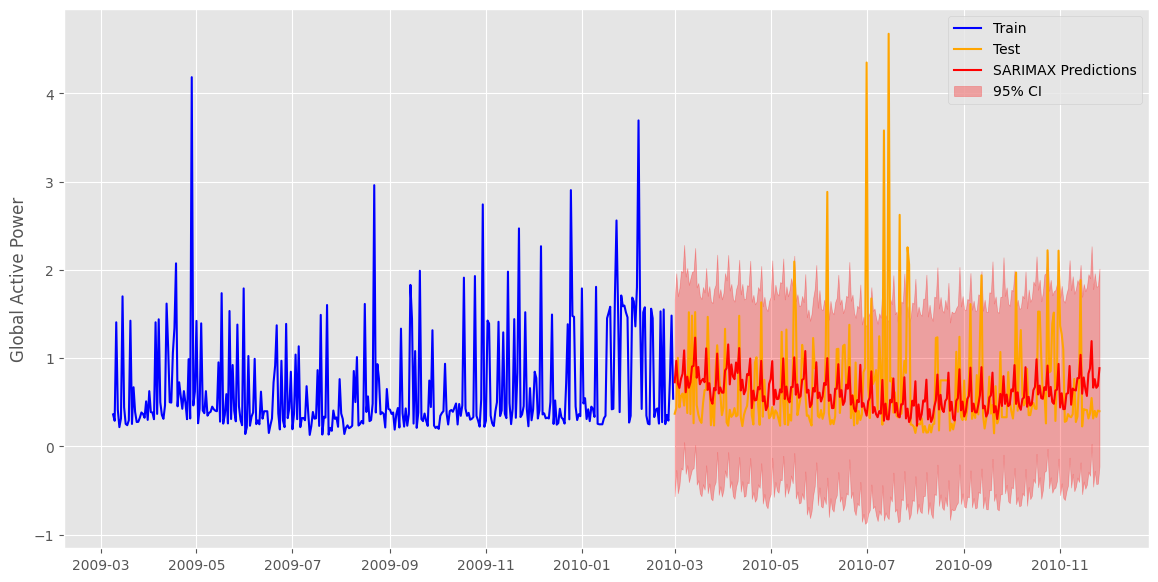

In [70]:

# Drop NaN values after creating lag features
df.dropna(inplace=True)
# Split data again after creating lag features
train = df[df.index < split_date]
test = df[df.index >= split_date]
# Train SARIMAX with additional features
sarimax_model = SARIMAX(train['Global_active_power'], 
                        order=(best_sarimax_params['p'], 
                               best_sarimax_params['d'], 
                               best_sarimax_params['q']),
                        seasonal_order=(best_sarimax_params['P'], 
                                        best_sarimax_params['D'], 
                                        best_sarimax_params['Q'], 
                                        best_sarimax_params['s']),
                        exog=train[['temp_lag30', 'humidity_lag30', 'temp_ma30', 'humidity_ma30']]
                       )
sarimax_fit = sarimax_model.fit(disp=False)
# Forecast with additional features
sarimax_predictions = sarimax_fit.forecast(steps=len(test), exog=test[['temp_lag30', 'humidity_lag30', 'temp_ma30', 'humidity_ma30']]
                                           )
# Create matrix DataFrame with actual values from test set
matrix = pd.DataFrame({
    'Actual': test['Global_active_power'],
    'SARIMAX_Predicted': sarimax_predictions
})
# Calculate metrics
mae_sarimax = mean_absolute_error(matrix['Actual'], matrix['SARIMAX_Predicted'])
mse_sarimax = mean_squared_error(matrix['Actual'], matrix['SARIMAX_Predicted'])
rmse_sarimax = np.sqrt(mse_sarimax)
r2_sarimax = r2_score(matrix['Actual'], matrix['SARIMAX_Predicted'])
print(f"SARIMAX with Features - MAE: {mae_sarimax}, MSE: {mse_sarimax}, RMSE: {rmse_sarimax}, R2: {r2_sarimax}")
# Plot SARIMAX predictions with additional features
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Global_active_power'], label='Train', color='blue')
plt.plot(test.index, test['Global_active_power'], label='Test', color='orange')
plt.plot(test.index, sarimax_predictions, label='SARIMAX Predictions', color='red')
conf_int_sarimax = sarimax_fit.get_forecast(
    steps=len(test),
    exog=test[['temp_lag1', 'humidity_lag1', 'temp_ma3', 'humidity_ma3']]
)
plt.fill_between(
    test.index,
    conf_int_sarimax.conf_int()['lower Global_active_power'],
    conf_int_sarimax.conf_int()['upper Global_active_power'],
    color='red', alpha=0.3, label='95% CI'
)
plt.ylabel('Global Active Power')
plt.legend()
plt.show()


SARIMAX - MAE: 0.24095258773571723, MSE: 0.13657395610165513, RMSE: 0.36955913748905617, R2: 0.6297404728635361


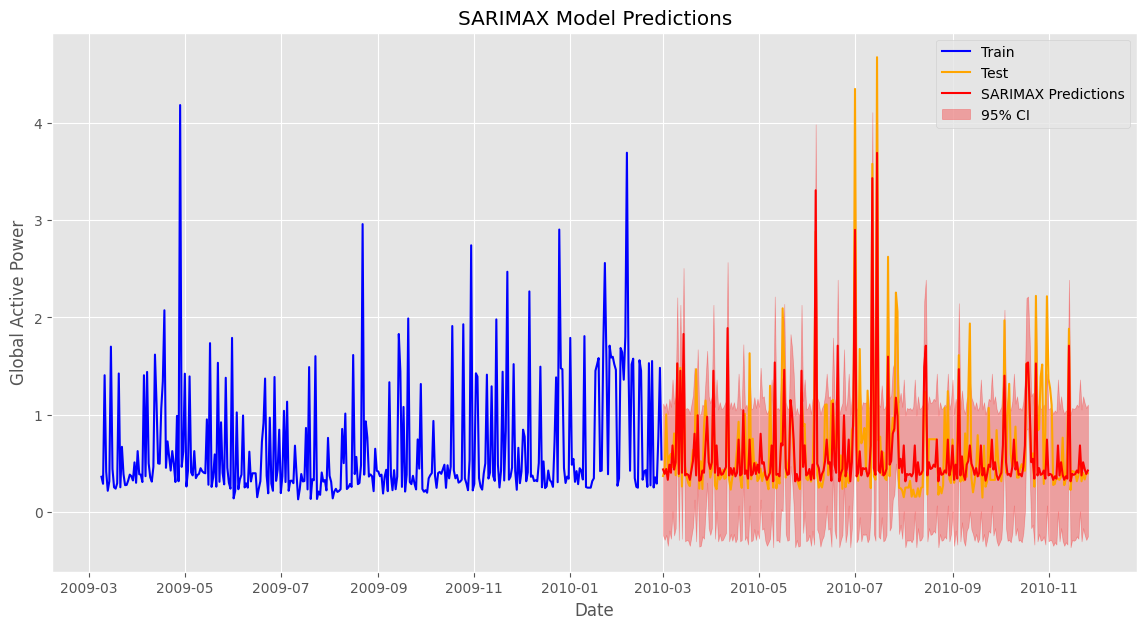

In [77]:
# Ensure exogenous variables are numeric and indices match
train_exog = train[['Sub_metering_3','Sub_metering_1','Sub_metering_2']].astype(float)
test_exog = test[['Sub_metering_3','Sub_metering_1','Sub_metering_2']].astype(float)

sarima_model = SARIMAX(
    train['Global_active_power'],
    order=(
        best_sarimax_params['p'], 
        best_sarimax_params['d'], 
        best_sarimax_params['q']
    ),
    seasonal_order=(
        best_sarimax_params['P'], 
        best_sarimax_params['D'], 
        best_sarimax_params['Q'], 
        best_sarimax_params['s']
    ),
    exog=train_exog
)
sarima_fit = sarima_model.fit(disp=False)
# Evaluate SARIMAX
sarimax_predictions = sarima_fit.forecast(
    steps=len(test),
    exog=test_exog,
    alpha=0.05  # 95% CI
)
matrix['SARIMAX_Predicted'] = sarimax_predictions
# Calculate metrics
mae_sarimax = mean_absolute_error(matrix['Actual'], matrix['SARIMAX_Predicted'])
mse_sarimax = mean_squared_error(matrix['Actual'], matrix['SARIMAX_Predicted'])
rmse_sarimax = np.sqrt(mse_sarimax)
r2_sarimax = r2_score(matrix['Actual'], matrix['SARIMAX_Predicted'])
print(f"SARIMAX - MAE: {mae_sarimax}, MSE: {mse_sarimax}, RMSE: {rmse_sarimax}, R2: {r2_sarimax}")
# Plot SARIMAX predictions
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Global_active_power'], label='Train', color='blue')
plt.plot(test.index, test['Global_active_power'], label='Test', color='orange')
plt.plot(test.index, sarimax_predictions, label='SARIMAX Predictions', color='red')
conf_int_sarimax = sarima_fit.get_forecast(
    steps=len(test),
    exog=test_exog
).conf_int()
plt.fill_between(
    test.index,
    conf_int_sarimax['lower Global_active_power'],
    conf_int_sarimax['upper Global_active_power'],
    color='red', alpha=0.3, label='95% CI'
)
plt.title('SARIMAX Model Predictions')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()

In [80]:
df['sub_met1_lag1'] = df['Sub_metering_1'].shift(1)
df['sub_met2_lag1'] = df['Sub_metering_2'].shift(1)
df['sub_met3_lag1'] = df['Sub_metering_3'].shift(1)
df['sub_met_rolling_mean7'] = df['Sub_metering_3'].rolling(window=7).mean()
df['sub_met_rolling_mean30'] = df['Sub_metering_3'].rolling(window=30).mean()
df['sub_met_rolling_std7'] = df['Sub_metering_3'].rolling(window=7).std()
df['sub_met_rolling_std30'] = df['Sub_metering_3'].rolling(window=30).std()

SARIMAX with Sub-metering Features - MAE: 0.45144954121387265, MSE: 0.3970409937674808, RMSE: 0.6301118898794728, R2: -0.07640003117957272


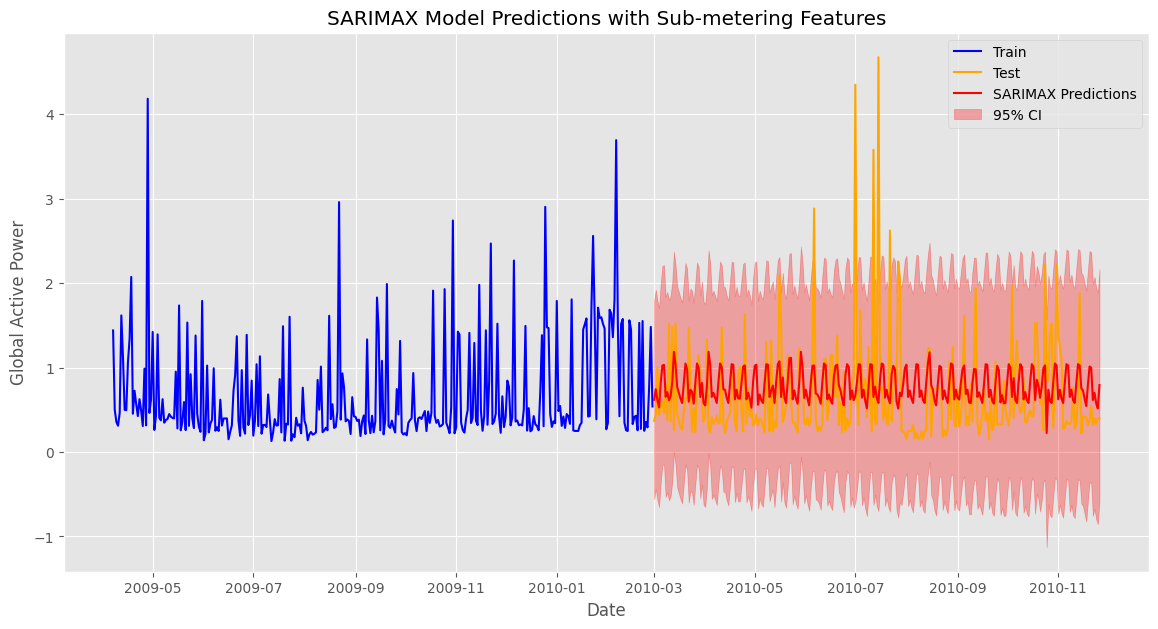

In [85]:
df.dropna(inplace=True)
# Split data again after feature engineering
train = df[df.index < split_date]
test = df[df.index >= split_date]

# Use the correct column names as created in CELL INDEX: 16
train_exog = train[['sub_met1_lag1', 'sub_met2_lag1', 'sub_met3_lag1',
                     ]].astype(float)
test_exog = test[['sub_met1_lag1', 'sub_met2_lag1', 'sub_met3_lag1',
                   ]].astype(float)

# Train SARIMAX with additional features
sarimax_model = SARIMAX(
    train['Global_active_power'],
    order=(best_sarimax_params['p'], 
           best_sarimax_params['d'], 
           best_sarimax_params['q']),
    seasonal_order=(best_sarimax_params['P'], 
                    best_sarimax_params['D'], 
                    best_sarimax_params['Q'], 
                    best_sarimax_params['s']),
    exog=train_exog
)

sarimax_fit = sarimax_model.fit(disp=False)
# Forecast with additional features
sarimax_predictions = sarimax_fit.forecast(
    steps=len(test),
    exog=test_exog,
    alpha=0.05  # 95% CI
)
# Create matrix DataFrame with actual values from test set
matrix = pd.DataFrame({
    'Actual': test['Global_active_power'],
    'SARIMAX_Predicted': sarimax_predictions
})
# Calculate metrics
mae_sarimax = mean_absolute_error(matrix['Actual'], matrix['SARIMAX_Predicted'])
mse_sarimax = mean_squared_error(matrix['Actual'], matrix['SARIMAX_Predicted'])
rmse_sarimax = np.sqrt(mse_sarimax)
r2_sarimax = r2_score(matrix['Actual'], matrix['SARIMAX_Predicted'])
print(f"SARIMAX with Sub-metering Features - MAE: {mae_sarimax}, MSE: {mse_sarimax}, RMSE: {rmse_sarimax}, R2: {r2_sarimax}")
# Plot SARIMAX predictions with sub-metering features
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Global_active_power'], label='Train', color='blue')
plt.plot(test.index, test['Global_active_power'], label='Test', color='orange')
plt.plot(test.index, sarimax_predictions, label='SARIMAX Predictions', color='red')
conf_int_sarimax = sarimax_fit.get_forecast(
    steps=len(test),
    exog=test_exog
).conf_int()
plt.fill_between(
    test.index,
    conf_int_sarimax['lower Global_active_power'],
    conf_int_sarimax['upper Global_active_power'],
    color='red', alpha=0.3, label='95% CI'
)
plt.title('SARIMAX Model Predictions with Sub-metering Features')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()

SARIMAX with Sub met Feature - MAE: 0.23721339605179767, MSE: 0.134330728940358, RMSE: 0.366511567266789, R2: 0.6358219854132885


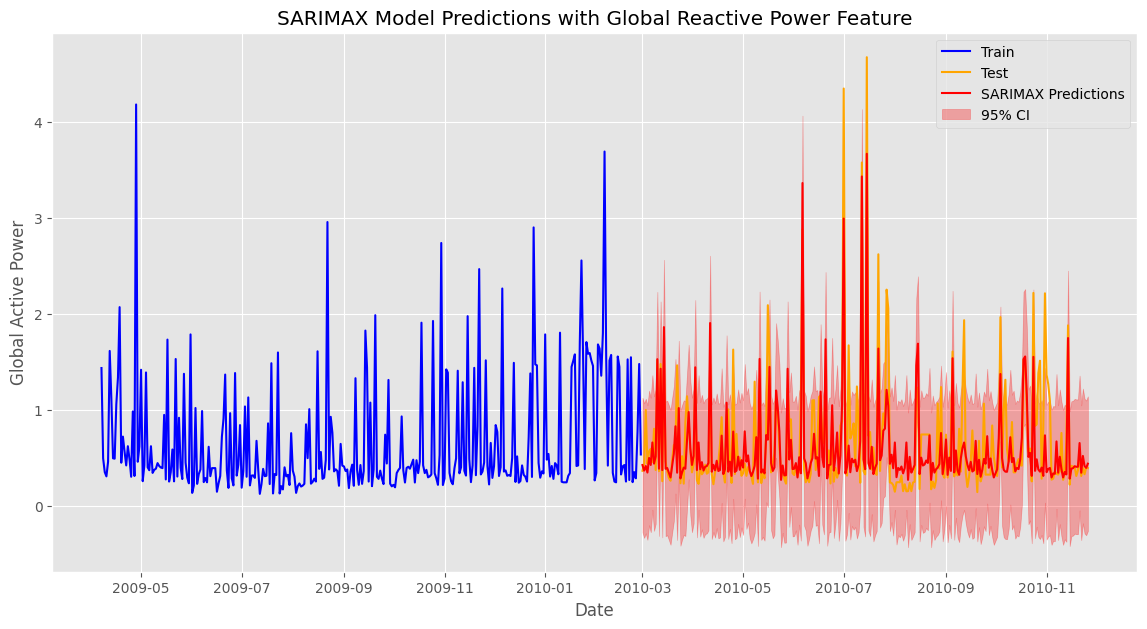

In [89]:
train_exog= train[['Sub_metering_3', 'Sub_metering_1', 'Sub_metering_2','Global_reactive_power']].astype(float)
test_exog = test[['Sub_metering_3', 'Sub_metering_1', 'Sub_metering_2','Global_reactive_power']].astype(float)
sarima_model = SARIMAX(
    train['Global_active_power'],
    order=(
        best_sarimax_params['p'], 
        best_sarimax_params['d'], 
        best_sarimax_params['q']
    ),
    seasonal_order=(
        best_sarimax_params['P'], 
        best_sarimax_params['D'], 
        best_sarimax_params['Q'], 
        best_sarimax_params['s']
    ),
    exog=train_exog
)
sarima_fit = sarima_model.fit(disp=False)
# Evaluate SARIMAX
sarimax_predictions = sarima_fit.forecast(
    steps=len(test),
    exog=test_exog,
    alpha=0.05  # 95% CI
)
# Create matrix DataFrame with actual values from test set
matrix = pd.DataFrame({
    'Actual': test['Global_active_power'],
    'SARIMAX_Predicted': sarimax_predictions
})
# Calculate metrics
mae_sarimax = mean_absolute_error(matrix['Actual'], matrix['SARIMAX_Predicted'])
mse_sarimax = mean_squared_error(matrix['Actual'], matrix['SARIMAX_Predicted'])
rmse_sarimax = np.sqrt(mse_sarimax)
r2_sarimax = r2_score(matrix['Actual'], matrix['SARIMAX_Predicted'])
print(f"SARIMAX with Sub met Feature - MAE: {mae_sarimax}, MSE: {mse_sarimax}, RMSE: {rmse_sarimax}, R2: {r2_sarimax}")
# Plot SARIMAX predictions with voltage feature
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Global_active_power'], label='Train', color='blue')
plt.plot(test.index, test['Global_active_power'], label='Test', color='orange')
plt.plot(test.index, sarimax_predictions, label='SARIMAX Predictions', color='red')
conf_int_sarimax = sarima_fit.get_forecast(
    steps=len(test),
    exog=test_exog
).conf_int()
plt.fill_between(
    test.index,
    conf_int_sarimax['lower Global_active_power'],
    conf_int_sarimax['upper Global_active_power'],
    color='red', alpha=0.3, label='95% CI'
)
plt.title('SARIMAX Model Predictions with Global Reactive Power Feature')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()
